In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns ; sns.set()

from google.colab import drive
drive.mount('/content/drive')

sys.path.append("/content/drive/MyDrive/GSOC-NMR-project/Work/Notebooks")
from auxillary_functions import *
from polynomial_featextract import poly_featextract

Mounted at /content/drive


In [2]:
# import raw data and params.txt file
datadir_path = "/content/drive/MyDrive/GSOC-NMR-project/Work/Data/2021-06-21_classify_datagen_all_funcs"

rawdata = load_data(datadir_path)
params = load_params(datadir_path)
ker_integrals = load_wlist(datadir_path) # load wlist.txt file

# Stencil type : {'0' : 'Gaussian', '1' : 'Power Law', '2' : 'RKKY'}

Finished loading rawdata into numpy array
Finsihed loading parameters file
finished loading kernel-integrals file.


In [3]:
print(rawdata.shape)
offset = 150
shifted_data, center = get_window(rawdata,2/3,width=offset)
print("The Echo pulse occurs at timestep:",center)

# Rescaled data
rscl_data = shifted_data / np.max(shifted_data,axis=1,keepdims=True)

(10500, 943)
The Echo pulse occurs at timestep: 628


In [4]:
y_classes = get_yclasses(params, ker_integrals)

# Pointwise features

In [49]:
import sklearn 
from sklearn.base import clone
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, classification_report, plot_confusion_matrix

In [6]:
rscl_df = pd.DataFrame(rscl_data, 
                       columns=[F'feat{i+1}' for i in range(len(rscl_data[0]+1))])
rscl_df.head()

,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11,feat12,feat13,feat14,feat15,feat16,feat17,feat18,feat19,feat20,feat21,feat22,feat23,feat24,feat25,feat26,feat27,feat28,feat29,feat30,feat31,feat32,feat33,feat34,feat35,feat36,feat37,feat38,feat39,feat40,...,feat261,feat262,feat263,feat264,feat265,feat266,feat267,feat268,feat269,feat270,feat271,feat272,feat273,feat274,feat275,feat276,feat277,feat278,feat279,feat280,feat281,feat282,feat283,feat284,feat285,feat286,feat287,feat288,feat289,feat290,feat291,feat292,feat293,feat294,feat295,feat296,feat297,feat298,feat299,feat300
0,0.007752,0.007970,0.007859,0.007362,0.006486,0.005304,0.003966,0.002714,0.001994,0.002240,0.003050,0.003977,0.004912,0.005853,0.006821,0.007831,0.008886,0.009962,0.010987,0.011842,0.012395,0.012538,0.012233,0.011535,0.010597,0.009640,0.008909,0.008615,0.008896,0.009777,0.011158,0.012818,0.014456,0.015753,0.016443,0.016368,0.015518,0.014031,0.012173,0.010274,...,0.007232,0.008779,0.010651,0.012499,0.013974,0.014804,0.014843,0.014102,0.012740,0.011034,0.009314,0.007892,0.007006,0.006765,0.007147,0.008007,0.009117,0.010217,0.011072,0.011524,0.011516,0.011093,0.010370,0.009490,0.008576,0.007702,0.006896,0.006155,0.005456,0.004751,0.003979,0.003113,0.002297,0.002097,0.002921,0.004195,0.005431,0.006386,0.006943,0.007078
1,0.007954,0.008204,0.008141,0.007703,0.006886,0.005750,0.004428,0.003127,0.002203,0.002156,0.002860,0.003798,0.004777,0.005768,0.006779,0.007827,0.008917,0.010024,0.011077,0.011962,0.012546,0.012728,0.012472,0.011835,0.010966,0.010080,0.009416,0.009176,0.009490,0.010383,0.011755,0.013390,0.014990,0.016243,0.016885,0.016765,0.015876,0.014360,0.012483,0.010577,...,0.007048,0.008521,0.010312,0.012065,0.013431,0.014139,0.014050,0.013184,0.011710,0.009914,0.008133,0.006691,0.005825,0.005651,0.006139,0.007133,0.008391,0.009640,0.010638,0.011223,0.011338,0.011026,0.010407,0.009622,0.008794,0.007998,0.007270,0.006617,0.006022,0.005428,0.004746,0.003904,0.002948,0.002241,0.002522,0.003646,0.004908,0.005939,0.006574,0.006770
2,0.008362,0.008377,0.008070,0.007380,0.006320,0.005004,0.003705,0.002974,0.003336,0.004407,0.005636,0.006833,0.007985,0.009136,0.010327,0.011577,0.012878,0.014184,0.015409,0.016428,0.017104,0.017328,0.017059,0.016351,0.015362,0.014322,0.013497,0.013124,0.013367,0.014270,0.015734,0.017530,0.019332,0.020792,0.021610,0.021597,0.020720,0.019109,0.017034,0.014844,...,0.006680,0.004955,0.003161,0.002609,0.003653,0.004712,0.005075,0.004610,0.003449,0.001902,0.000592,0.001249,0.001900,0.001845,0.001082,0.000412,0.001964,0.003593,0.004948,0.005842,0.006216,0.006138,0.005770,0.005298,0.004852,0.004459,0.004079,0.003681,0.003262,0.002817,0.002313,0.001764,0.001522,0.002185,0.003444,0.004810,0.005980,0.006746,0.006991,0.006697
3,0.071041,0.116141,0.157928,0.186144,0.193928,0.176297,0.131342,0.063197,0.047574,0.143523,0.244109,0.331524,0.394783,0.427744,0.430725,0.411673,0.385972,0.372340,0.382148,0.410700,0.443466,0.467947,0.478935,0.478557,0.474363,0.476278,0.492618,0.526711,0.576429,0.636274,0.699532,0.759315,0.808905,0.842098,0.853650,0.839802,0.798746,0.730959,0.639387,0.529448,...,0.235294,0.135007,0.063859,0.099112,0.173708,0.244687,0.307738,0.362627,0.409473,0.448187,0.478734,0.501774,0.519287,0.534609,0.551404,0.571638,0.593824,0.613037,0.622808,0.617796,0.595924,0.559370,0.514321,0.469429,0.433229,0.411235,0.404521,0.410693,0.425682,0.444243,0.459769,0.464925,0.453342,0.421539,0.370215,0.304493,0.233116,0.166677,0.114716,0.081142
4,0.008419,0.008817,0.008915,0.008637,0.007955,0.006909,0.005599,0.004194,0.002949,0.002305,0.002617,0.003497,0.004533,0.005599,0.006677,0.007779,0.008908,0.010039,0.011106,0.012004,0.012620,0.012869,0.012727,0.012255,0.011597,0.010952,0.010531,0.010513,0.011006,0.012017,0.013439,0.015058,0.016584,0.017720,0.018223,0.017961,0.016947,0.015341,0.013419,0.011513,...,0.006159,0.007627,0.009420,0.011146,0.012434,0.013009,0.012752,0.011716,0.010124,0.008314,0.006670,0.005512,0.004990,0.005112,0.005866

In [7]:
X_train_ts , X_test_ts, y_train_ts, y_test_ts = train_test_split(rscl_data, params['stencil_type'], test_size=0.2,
                                                     stratify=params['stencil_type'], random_state=101)

In [97]:
basemodel_ts = RandomForestClassifier(oob_score=True, n_jobs=-1)


In [98]:
basemodel_ts.fit(X_train_ts, y_train_ts)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [99]:
bm_pred_ts = basemodel_ts.predict(X_test_ts)
f1_score(y_test_ts, bm_pred_ts, average='weighted')

0.9814929209102493

In [100]:
y_pred_ts = basemodel_ts.predict(X_test_ts)
wrongly_classified = np.where(y_test_ts != y_pred_ts)[0]
wrongly_classified

array([   7,   37,  133,  464,  538,  564,  590,  618,  693,  761,  868,
        900,  949, 1042, 1081, 1089, 1135, 1164, 1193, 1235, 1245, 1250,
       1257, 1260, 1281, 1317, 1344, 1365, 1454, 1464, 1501, 1545, 1549,
       1752, 1808, 1842, 1860, 1945, 2073])

In [101]:
confusion_matrix(y_test_ts, y_pred_ts, normalize='true')

array([[0.96714286, 0.        , 0.03285714],
       [0.        , 0.98714286, 0.01285714],
       [0.00857143, 0.00142857, 0.99      ]])

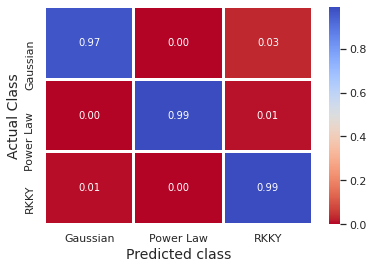

In [102]:
sns.heatmap(confusion_matrix(y_test_ts, y_pred_ts, normalize='true'),
            annot=True, fmt='.2f',
            cmap='coolwarm_r', lw=2)
plt.xticks(np.arange(3)+0.5,['Gaussian','Power Law','RKKY'])
plt.yticks(np.arange(3)+0.5,['Gaussian','Power Law','RKKY'])
plt.ylabel('Actual Class', fontsize=14)
plt.xlabel('Predicted class', fontsize=14)

plt.show()

In [103]:
wrongly_classified = np.where(y_test_ts != y_pred_ts)[0]
wrong_y = y_test_ts.iloc[wrongly_classified]
wrongly_classified_y_test = wrong_y[wrong_y == 0]

In [132]:
# Correlation length for wrongly classified curves

In [150]:
np.random.seed(101)
ker_integrals = np.random.permutation(ker_integrals)
xi = np.random.permutation(params['ξ'])

In [151]:
params['ξ'].describe()

count    10500.000000
mean         1.324000
std          1.289557
min          0.000000
25%          0.000000
50%          1.342172
75%          1.951566
max         18.467310
Name: ξ, dtype: float64

In [152]:
xi[wrongly_classified].mean()

1.2178967

In [144]:
ker_integrals[wrong_y.index].mean(), ker_integrals[wrong_y.index].std()

(0.08434047299164758, 0.02221259300952853)

In [128]:
# Kernel integrals of wrongly classified curves

gaus_as_rkky_stats = ker_integrals.iloc[wrong_y.index].describe().T
gaus_as_rkky_stats

,count,mean,std,min,25%,50%,75%,max
0,39.0,0.083169,0.029869,0.041717,0.051064,0.094835,0.112539,0.11916


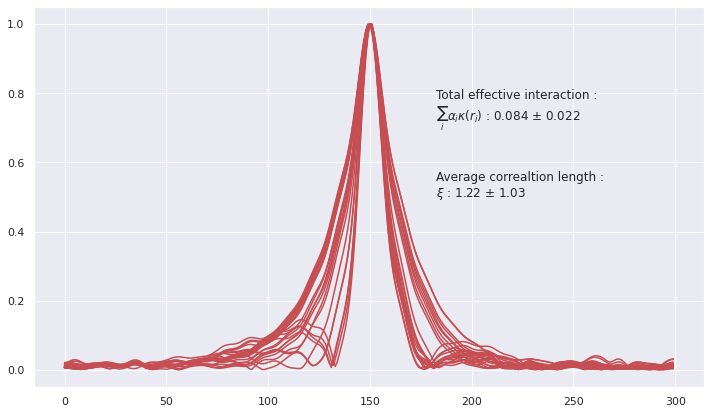

In [174]:
fig, ax = plt.subplots(figsize=(12,7))
for curve in rscl_df.to_numpy()[wrongly_classified_y_test.index,:]:
    ax.plot(curve,'r')

ax.text(0.6,0.7,"Total effective interaction : \n" + r"$\sum_i \alpha_i \kappa(r_i) $" + " : 0.084 $\pm$ 0.022",
        fontsize=12, transform=ax.transAxes)
ax.text(0.6,0.5,"Average correaltion length :\n"+  r"$\xi$" + f" : {xi[wrongly_classified].mean():.3} $\pm$ {xi[wrongly_classified].std():.3}",
        fontsize=12, transform=ax.transAxes)
plt.show()

In [95]:
# Kernel integrals for gaussian
ker_integrals[:3500].describe()

,0
count,3500.000000
mean,0.081111
std,0.022297
min,0.040021
25%,0.062557
50%,0.081229
75%,0.099886
max,0.119994


In [106]:
# Kernel integrals for power-law
ker_integrals[3500:7000].describe()

,0
count,3500.000000
mean,0.086046
std,0.021755
min,0.040016
25%,0.068985
50%,0.088802
75%,0.104764
max,0.119998


In [96]:
# Kernel integrals for RKKY
ker_integrals[7000:10500].describe()

,0
count,3500.000000
mean,0.077193
std,0.023112
min,0.040030
25%,0.056741
50%,0.075333
75%,0.096388
max,0.119984


In [37]:
ker_integrals.iloc[y_test_ts.iloc[wrongly_classified].index].describe()

,0
count,40.000000
mean,0.077853
std,0.030884
min,0.040329
25%,0.047511
50%,0.067070
75%,0.110641
max,0.119160


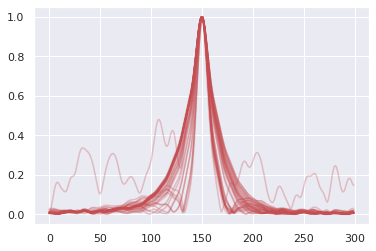

In [38]:
true_gaus = rscl_df.iloc[y_test_ts.iloc[wrongly_classified].index,:]
for curve in true_gaus.to_numpy():
    plt.plot(curve,'r',alpha=0.3)

In [24]:
incorrect_class  =list(zip(y_test_ts.iloc[wrongly_classified].values,y_pred_ts[wrongly_classified] ))
incorrect_class

[(0.0, 2.0),
 (0.0, 2.0),
 (0.0, 2.0),
 (0.0, 2.0),
 (0.0, 2.0),
 (1.0, 2.0),
 (2.0, 0.0),
 (0.0, 2.0),
 (1.0, 2.0),
 (2.0, 0.0),
 (0.0, 2.0),
 (0.0, 2.0),
 (0.0, 2.0),
 (2.0, 0.0),
 (1.0, 2.0),
 (2.0, 0.0),
 (1.0, 2.0),
 (0.0, 2.0),
 (1.0, 2.0),
 (0.0, 2.0),
 (0.0, 2.0),
 (0.0, 2.0),
 (0.0, 2.0),
 (1.0, 2.0),
 (0.0, 2.0),
 (2.0, 1.0),
 (0.0, 2.0),
 (0.0, 2.0),
 (1.0, 2.0),
 (0.0, 2.0),
 (0.0, 2.0),
 (1.0, 2.0),
 (2.0, 0.0),
 (0.0, 1.0),
 (0.0, 2.0),
 (2.0, 0.0),
 (1.0, 2.0),
 (0.0, 2.0),
 (0.0, 2.0),
 (0.0, 2.0)]